**Задача**: разработка модели предсказания оценки по тексту отзыва.
    
**Данные**: отзывы о товарах с сайта mvideo.ru, оценки, которые поставлены авторами отзыва, категория и брэнд товара. 

**Цель**: Предсказание общей оценки товара

**Формат предоставления решения**: Ссылка на репозиторий на GitHub с исходным кодом программы, решающей поставленную задачу. На вход программа должна принимать данные в исходном виде (feedback), разбивать на train и test, обучать на train модель и демонстрировать ее качество на test. Репозиторий должен содержать проект для среды разработки и инструкцию по сборке и запуску. Рекомендуем использовать Jupyter Notebook, но окончательный выбор инструментария остаётся за вами.

**Предложенное решение**

Предлагаемая "программа" предсказывает числовое значение рейтинга с помощью линейной регрессии, использующей как признаки TF-IDF счётчики слов и биграмм, содержащихся в запросе; полученное значение нормируется монотонной функцией от 1 до 5.

Модель использует исключительно текст "общих" комментариев, хотя в датасете присутствуют и иные признаки (в т.ч. положительные и отрицательные отзывы). Не зная о планируемом применении модели, мы сделали её максимально простой, и потому переносимой. 

# Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

import pymorphy2
import nltk

In [2]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score

Подгружаем из интернетов пунктуацию

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Загружаем файл с данными

In [4]:
data = pd.read_csv('feedback.csv/X_train.csv')
data.shape

(15587, 11)

In [5]:
data.dtypes

sku                   int64
categoryLevel1Id      int64
categoryLevel2Id      int64
brandId               int64
property             object
userName             object
reting              float64
date                 object
comment              object
commentNegative      object
commentPositive      object
dtype: object

In [6]:
data.reting.describe()

count    15587.000000
mean         4.118496
std          1.316966
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reting, dtype: float64

Почти все оценки - пятёрки. Для MVIDEO это, конечно, хорошо, но для системы рейтингования, наверное, не очень. 

Посколькую рейтингов разных много, и они упорядочены, проще всего предсказывать их регрессией. 

In [7]:
data.reting.value_counts().sort_index()

1.0    1468
1.3       6
1.7       1
2.0     854
2.3      14
2.7      15
3.0    1245
3.3      16
3.7      16
4.0    2609
4.3      54
4.7      78
5.0    9211
Name: reting, dtype: int64

Разбираемся с временным периодом

In [8]:
data.date = pd.to_datetime(data.date)

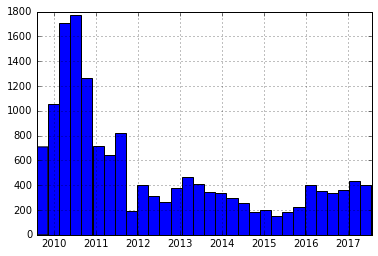

In [9]:
data.date.hist(bins=30);

In [10]:
print((data.date<pd.Timestamp('2016-01-01')).mean())

0.855520626163


В качестве теста можно взять 2016-2017 годы, это будет честно.

In [11]:
data.sort_values('date', inplace=True)

Из года в год средняя оценка колебалась, но не то чтобы значительно

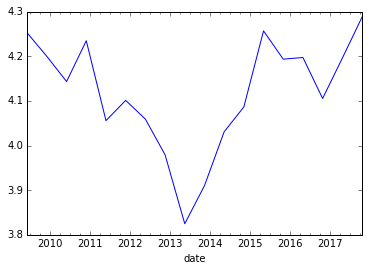

In [12]:
data.reting.groupby(data.date.dt.round('180d')).mean().plot();

Разделяем выборку на тестовую и тренировочную

In [13]:
train_index = data[data.date<pd.Timestamp('2016-01-01')].index
test_index = data[data.date>=pd.Timestamp('2016-01-01')].index
print('train:{}, test:{} obs'.format(train_index.shape[0], test_index.shape[0]))

train:13335, test:2252 obs


# Предобработка

Заменяем смайлики и прочие средства выразительности на служебные слова

In [14]:
import re

reg_smiles = {
    re.compile(r"[\)]{2,}"): ' _BRACKETS_POSITIVE ',
    re.compile(r"[\(]{2,}"): ' _BRACKETS_NEGATIVE ',
    re.compile(';-?\)'): ' _SMILE_GRIN ',
    re.compile(r":[-]?\)"): ' _SMILE_POSITIVE ',
    re.compile(r":[-]?\("): ' _SMILE_NEGATIVE ',
    re.compile(r"!!!"): ' _MANY_EXCLAMATIONS ',
    re.compile(r"[.]{3,}"): ' _PERIOD ',
}

def replace_smiles(text):
    for reg, repl in reg_smiles.items():
        text = re.sub(reg, repl, text)
    return text

Разбиваем тексты на слова

In [15]:
def tokenize(text):
    return [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
print(tokenize(data.comment[0]))

['2,5', 'года', 'работала', 'и', 'все', '...', 'устала', '!', 'Лампочка', 'горит', 'и', 'больше', 'ничего', '!']


Приводим слова к нормальной форме

In [16]:
morph = pymorphy2.MorphAnalyzer()

In [17]:
def lemmatize(words):
    return [morph.parse(word)[0].normal_form for word in words]
print(lemmatize(tokenize(data.comment[0])))

['2,5', 'год', 'работать', 'и', 'весь', '...', 'устать', '!', 'лампочка', 'гореть', 'и', 'большой', 'ничто', '!']


Теперь очень долго вычисляем всё это

In [18]:
lemma_bags = data.comment.apply(replace_smiles).apply(tokenize).apply(lemmatize)

# Регрессия

Оказывается, встроенные инструменты позволяют куда более точную оценку тональности

In [19]:
new_texts = lemma_bags.apply(lambda x:' '.join(x))

In [20]:
def get_bigrams(lemmas):
    return [w1+'_'+w2 for w1, w2 in zip(lemmas[:-1], lemmas[1:])]
def add_bigrams(lemmas):
    return lemmas + get_bigrams(lemmas)
print(add_bigrams('мама мыла раму'.split()))

['мама', 'мыла', 'раму', 'мама_мыла', 'мыла_раму']


In [21]:
new_bigrams = lemma_bags.apply(add_bigrams).apply(lambda x:' '.join(x))

In [22]:
vec = TfidfVectorizer(min_df=5, max_df = 0.5)
vec.fit(new_texts)
print(len(vec.vocabulary_))

7338


Первый же заход даёт точность 38% (в эр-квадратах)

In [23]:
pipe = make_pipeline(vec, Ridge(1))
cross_val_score(pipe, new_texts, data.reting)

array([ 0.38404026,  0.47581768,  0.38093819])

Биграммы доводят уже до 44%

In [25]:
cross_val_score(pipe, new_bigrams[train_index], data.reting[train_index])

array([ 0.44763365,  0.49826341,  0.51881202])

In [26]:
pipe.fit(new_bigrams[train_index], data.reting[train_index]);

In [27]:
inv_idx = {value:key for key, value in pipe.steps[0][1].vocabulary_.items()}
c = pipe.steps[1][1].coef_
best = [inv_idx[i] for i in np.argsort(c)[-10:]]
worst = [inv_idx[i] for i in np.argsort(c)[:10]]
print(', '.join(best))
print(', '.join(worst))

не_пожалеть, ни_раз, нравиться, но_это, супер, довольный, у_я, хороший, отлично, отличный
ужасный, не_советовать, отвратительный, не_рекомендовать, не_покупать, не_понравиться, не_брать, не_довольный, ужас, сломаться


In [28]:
raw_preddiction = cross_val_predict(pipe, new_bigrams[train_index], data.reting[train_index])

Картинка показывает, что прогноз модели может быть ещё здорово улучшен за счёт примерения нелинейных преобразований 

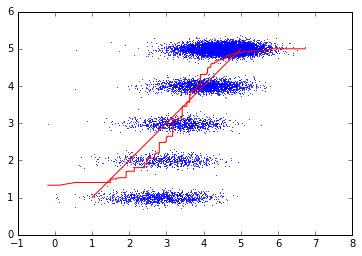

In [29]:
plt.scatter(raw_preddiction, data.reting[train_index]+np.random.normal(size = len(train_index), scale = 0.1), lw=0, s=1);
plt.plot([1, 5], [1, 5], color = 'red')

iso = IsotonicRegression(y_min = -10, y_max=10, out_of_bounds='clip').fit(raw_preddiction, data.reting[train_index])
plt.plot(pd.Series(raw_preddiction).sort_values(), iso.predict(pd.Series(raw_preddiction).sort_values()), color = 'red');

Если нормально учесть нелинейность, модель ещё точнее

In [30]:
print(r2_score(data.reting[train_index], iso.predict(raw_preddiction)))

0.548557130558


# Проверка на тестовых данных 

In [31]:
test_predict = iso.predict(pipe.predict(new_bigrams[test_index]))

На тестовых данных из будущего модель отрабатывает сильно хуже, чем на кросс-валидации - видимо, данные 2010-2015 года не совсем релевантны для прогнозов в 2016-2017 году.


In [32]:
print(r2_score(data.reting[test_index], test_predict))

0.356912145724


Но в реальности мы бы могли дообучать модель хоть каждый день, поэтому данная проблема не так страшна. 